# Combine Data Sets into one Data Cube

In this tutorial we are going to combine data from different satellites into one data cube. In detail we are going to...
- query a STAC catalog to get acquisitions within the same extents (temporal, spatial and spectrally) taking into account the cloud cover.
- Load the found items into one data cube
- Calculate the NDVI
- Compare the timeseries of values per satellite (*ideally they should be radiometrically harmonized, e.g. [sen2like](https://github.com/senbox-org/sen2like), we are not doing this for this tutorial*)
- Create a temporal aggregate to combine the information from the two satellites and densify the time series


 This notebook can be run in the micromamba default Environment or you can create your own user Environment (called tutorialEnv in the example) using:
 
`!micromamba install -y -n tutorialEnv jupyter xarray rioxarray odc-stac odc-geo pystac-client dask folium geopandas zarr jupyter-server-proxy`

and then starting a new Jupyter Environment from the portal specifying the Name of your newly created env in the  custom Environment Field

In [1]:
#!micromamba install -y -n tutorialEnv jupyter xarray rioxarray odc-stac odc-geo pystac-client dask folium geopandas zarr jupyter-server-proxy

In [1]:
import os
import time
import socket
import xarray
import rioxarray
from odc import stac as odc_stac
from odc.geo import geobox
from pystac_client import Client as pystacclient
import dask
from dask.distributed import Client
import folium
import folium.plugins as folium_plugins
import geopandas as gpd
import numpy as np

In [2]:
#for now we use the Home Folder ~
dir_out = '~/xarray-dask-tutorial'

# Stac settings 

collection = 'sentinel-2-c1-l2a'

# input data settings
year = 2023
resolution = 60
mgrs = 'MGRS-32UPU'
max_cloud_cover = 60
bands = ['nir', 'red']

filename_base = f'S2_y{year}_res{resolution}_median_{mgrs}.zarr'
filename = os.path.join(dir_out, filename_base)

# data cube settings
bands = ['nir', 'red']
resolution = 60

# dask settings
dir_out = '~/xarray-dask-tutorial'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
dask_chunksize=1024
dask_threads = 1

# Explore the STAC catalog

In [4]:
catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
catalog = pystacclient.open(catalog_url)
collections = list(catalog.get_all_collections())
for collection in collections:
    print(f"{collection.id} | {collection.title}")

sentinel-1-grd | Sentinel-1 GRD Level-1
modis-13a2-061 | MOD13A2.061 & MYD13A2.061: MODIS Vegetation Indices 16-Day (1km)
modis-13q1-061 | MOD13Q1.061 & MYD13Q1.061: MODIS Vegetation Indices 16-Day (250m)
sentinel-2-c1-l1c | Sentinel-2 Collection 1 Level-1C
modis-09gq-061 | MOD09GQ.061 & MYD09GQ.061: MODIS Surface Reflectance Daily (250m)
sentinel-1-slc | Sentinel-1 SLC Level-1
sentinel-2-l1c | Sentinel-2 Level-1C
cop-dem-glo-90 | Copernicus DEM GLO-90
viirs-09ga-001 | VNP09GA.001: VIIRS/NPP Surface Reflectance Daily L2GD 500m and 1km
cop-dem-glo-30 | Copernicus DEM GLO-30
viirs-13a1-001 | VNP13A1.001: VIIRS Vegetation Indices 16-Day (500m)
sentinel-3-olci-l1-efr | Sentinel-3 OLCI Level-1 EFR
landsat-tm-c2-l2 | Landsat 4-5 TM Collection 2 Level-2
landsat-etm-c2-l2 | Landsat 7 ETM+ Collection 2 Level-2
sentinel-1-nrb | Sentinel-1 Normalized Radar Backscatter (NRB)
landsat-ot-c2-l2 | Landsat 8-9 OLI/TIRS Collection 2 Level-2
sentinel-2-c1-l2a | Sentinel-2 Collection 1 Level-2A
viirs-15a2

# Query data from the STAC catalog

Let's define the parameters we want to use for both collections.

In [16]:
max_cloud_cover = 25

query = {
    'eo:cloud_cover': {
        "gte": 0,
        "lte": max_cloud_cover
    }
}

start = '2023-01-01T00:00:00Z'
end = '2023-12-31T23:59:59Z'

bands = ['nir', 'red']

bbox = [11.608051,48.552671,11.630625,48.563181] # Gerolzhausen in der Hallertau


Search Sentinel-2

In [17]:
collection = 'sentinel-2-c1-l2a'
search_s2 = catalog.search(collections=[collection],
                           bbox=bbox,
                           datetime=[start, end],
                           query=query)
items_s2 = list(search_s2.items())
print(f'Found {len(items_s2)} Scenes') 

TypeError: Client.search() got an unexpected keyword argument 'bands'

Search Landsat 7

In [10]:
collection = 'landsat-etm-c2-l2'
search_ls = catalog.search(collections=[collection],
                           bbox = bbox,
                           datetime=[start, end],
                           query=query)
items_ls = list(search_ls.items())
print(f'Found {len(items_ls)} Scenes') 

Found 10 Scenes


# Visualize the covered area

In [15]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)
fullscreen = folium_plugins.Fullscreen()
style_s2 = {'fillColor': '#00000000', "color": "#ff0000", "weight": 1}
style_ls = {'fillColor': '#00000000', "color": "#0000ff", "weight": 1}

footprints_s2 = folium.GeoJson(
    gpd.GeoDataFrame.from_features([item.to_dict() for item in items_s2]).to_json(),
    name='S2 footprints',
    style_function=lambda x: style_s2,
    control=True
)

footprints_ls = folium.GeoJson(
    gpd.GeoDataFrame.from_features([item.to_dict() for item in items_ls]).to_json(),
    name='LS footprints',
    style_function=lambda x: style_ls,
    control=True
)

from shapely.geometry import box
bbox_map = box(*bbox)
bbox_map = gpd.GeoDataFrame({"geometry": [bbox_map]})
bbox_map = bbox_map.to_json()
bbox_map = folium.GeoJson(
    bbox_map,
    name='Bbox Search',
    control=True
)    

bbox_map.add_to(map)
footprints_s2.add_to(map)
footprints_ls.add_to(map)
layer_control.add_to(map)
fullscreen.add_to(map)
map.fit_bounds(map.get_bounds())
map

# Load the STAC items into xarray

Define some general settings for the data cubes and the dask cluster.

In [23]:
# data cube settings
bands_s2 = ['nir', 'red']
bands_ls = ['nir08', 'red'] # unfortunately they don't have the same band aliases.
resolution = 60

# dask settings
dir_out = '~/xarray-dask-tutorial'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
dask_chunksize=1024
dask_threads = 1

Load the S2 stack and calculate NDVI

In [26]:
cube_s2 = odc_stac.load(
    items_s2,
    bands=bands_s2,
    resolution=resolution,
    bbox=bbox,
    groupby='solar_day',
    chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
    anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)
# temporal chunking
cube_s2 = cube_s2.chunk(chunks={'time': -1})

# calc ndvi
cube_s2["ndvi"]=(cube_s2.nir - cube_s2.red)/(cube_s2.nir + cube_s2.red)

# write CF-compliant CRS representation
#cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)
cube_s2

<xarray.Dataset>
Dimensions:      (y: 21, x: 29, time: 28)
Coordinates:
  * y            (y) float64 5.382e+06 5.382e+06 ... 5.381e+06 5.381e+06
  * x            (x) float64 6.924e+05 6.925e+05 ... 6.941e+05 6.941e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2023-02-07T10:11:09.024000 ... 2023-12...
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(28, 21, 29), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(28, 21, 29), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(28, 21, 29), meta=np.ndarray>

Load the LS cube and calculate NDVI.

In [27]:
cube_ls = odc_stac.load(
    items_ls,
    bands=bands_ls,
    resolution=resolution,
    bbox=bbox,
    groupby='solar_day',
    chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
    anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)
# temporal chunking
cube_ls = cube_ls.chunk(chunks={'time': -1})

# calc ndvi
cube_ls["ndvi"]=(cube_ls.nir08 - cube_ls.red)/(cube_ls.nir08 + cube_ls.red)

# write CF-compliant CRS representation
#cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)
cube_ls

<xarray.Dataset>
Dimensions:      (y: 21, x: 29, time: 10)
Coordinates:
  * y            (y) float64 5.382e+06 5.382e+06 ... 5.381e+06 5.381e+06
  * x            (x) float64 6.924e+05 6.925e+05 ... 6.941e+05 6.941e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2023-04-06T07:57:16.713956 ... 2023-10...
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(10, 21, 29), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(10, 21, 29), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(10, 21, 29), meta=np.ndarray>

In [31]:
# combine the two datacubes into one only keeping the ndvi band
#s2 = cube_s2.compute()
s2

<xarray.Dataset>
Dimensions:      (y: 21, x: 29, time: 28)
Coordinates:
  * y            (y) float64 5.382e+06 5.382e+06 ... 5.381e+06 5.381e+06
  * x            (x) float64 6.924e+05 6.925e+05 ... 6.941e+05 6.941e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2023-02-07T10:11:09.024000 ... 2023-12...
Data variables:
    nir          (time, y, x) uint16 4592 5088 4485 4364 ... 3002 3796 3996 2393
    red          (time, y, x) uint16 2020 1520 1728 1733 ... 1617 1505 1487 1392
    ndvi         (time, y, x) float64 0.389 0.54 0.4437 ... 0.4322 0.4576 0.2645

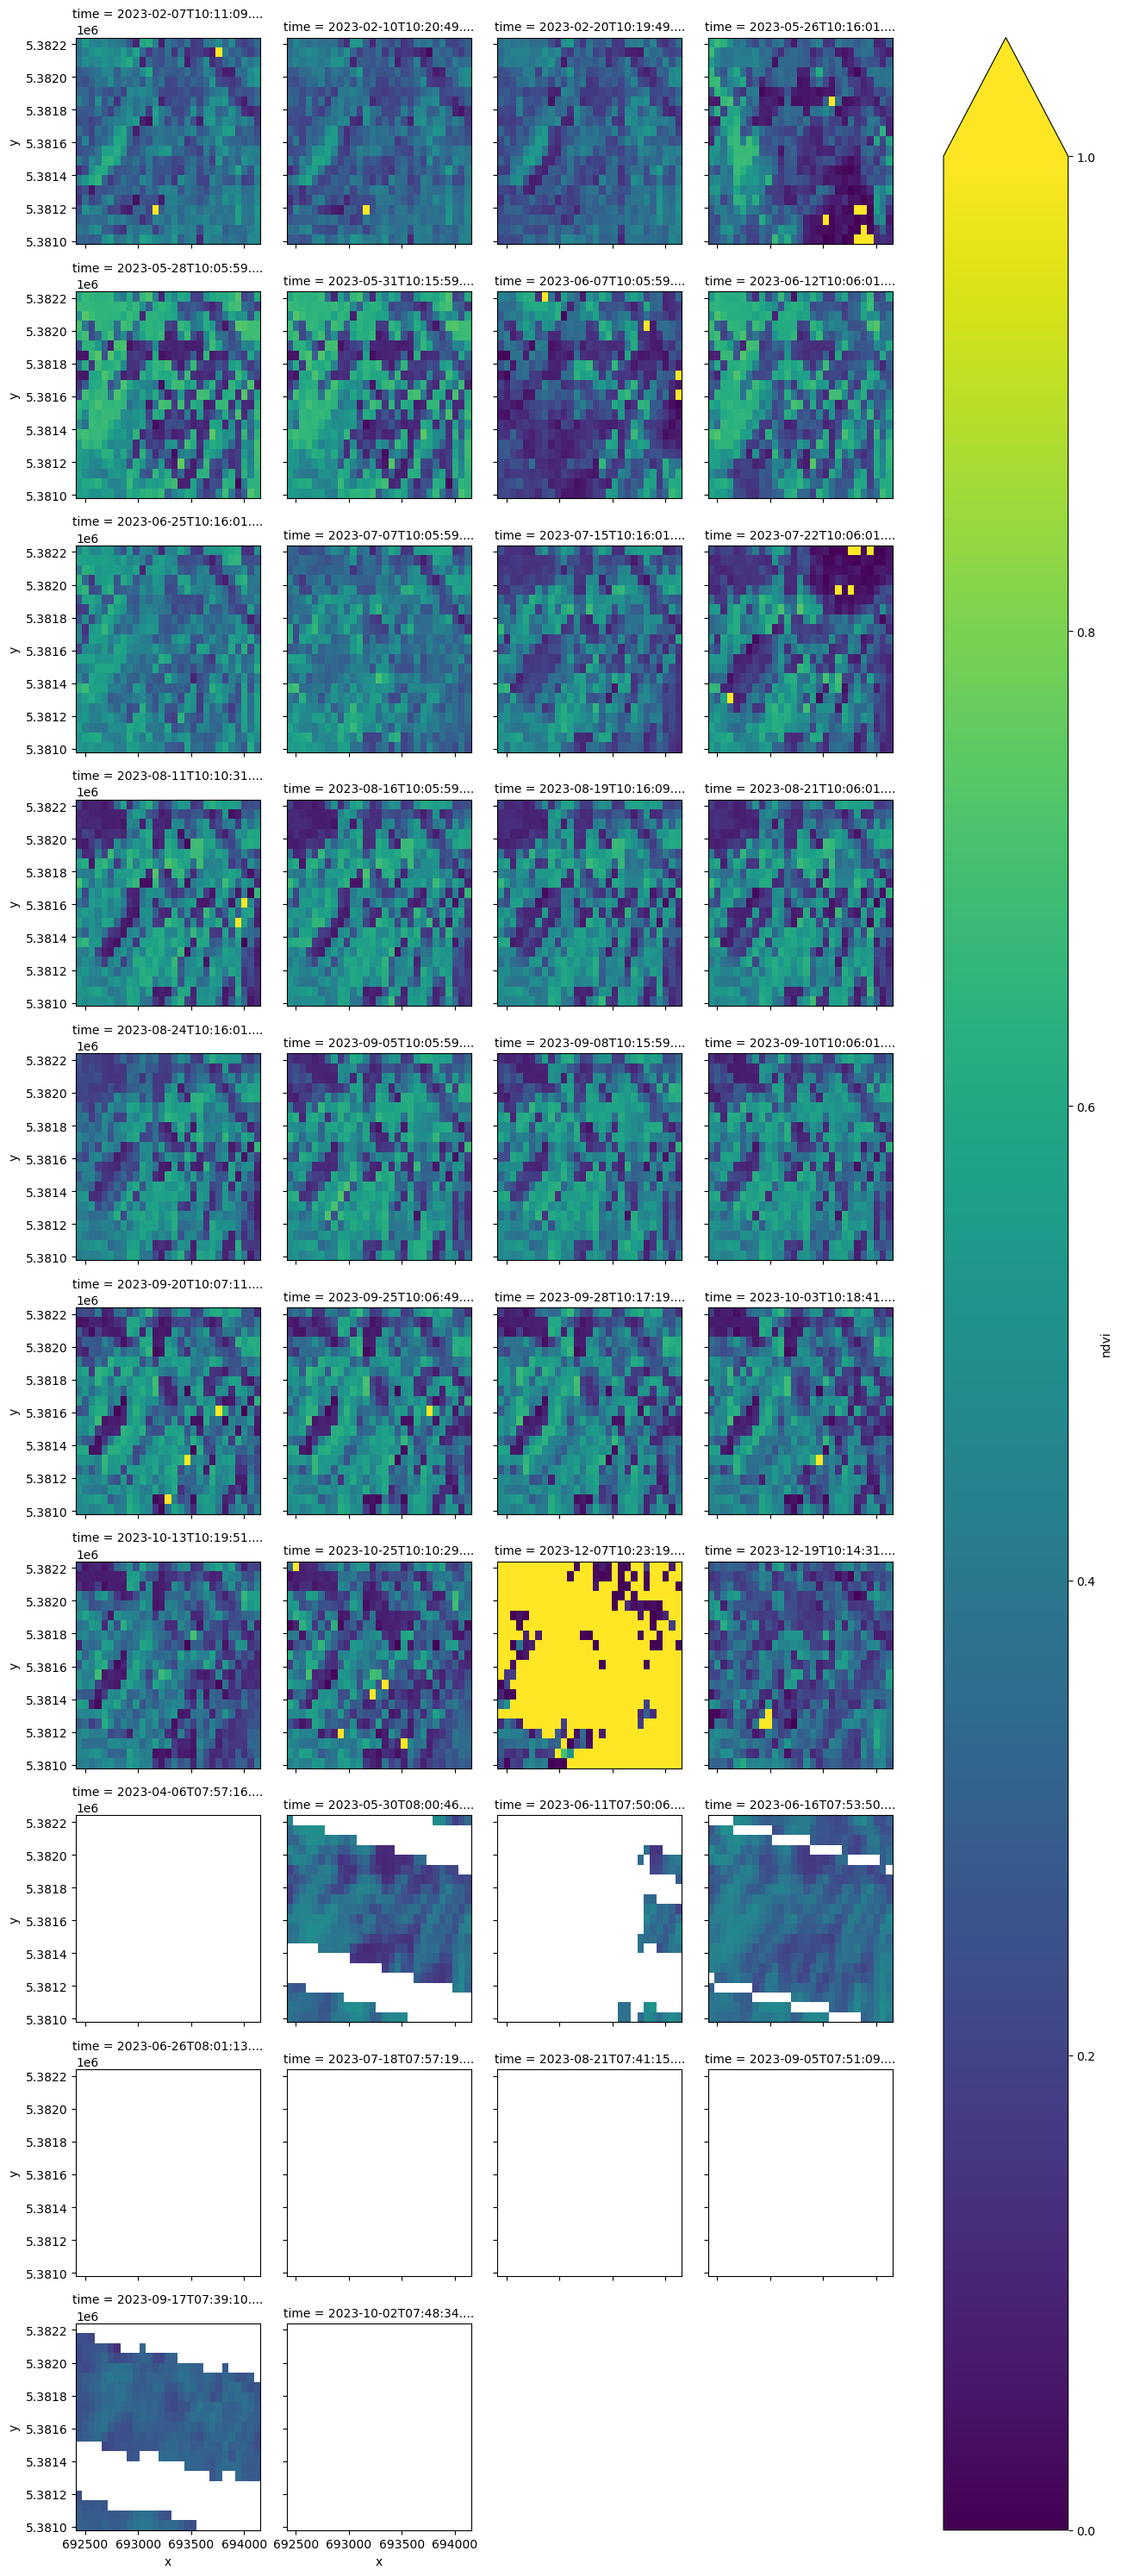

In [54]:
#s2.ndvi.isel(time=15).plot.imshow(vmin=0, vmax=1)
cube_ndvi = xarray.concat([cube_s2.ndvi, cube_ls.ndvi], dim='time')
#cube_ndvi
g_simple = cube_ndvi.plot(x="x", y="y", col="time", col_wrap=4, vmin=0, vmax=1)

AttributeError: Line2D.set() got an unexpected keyword argument 'vmin'

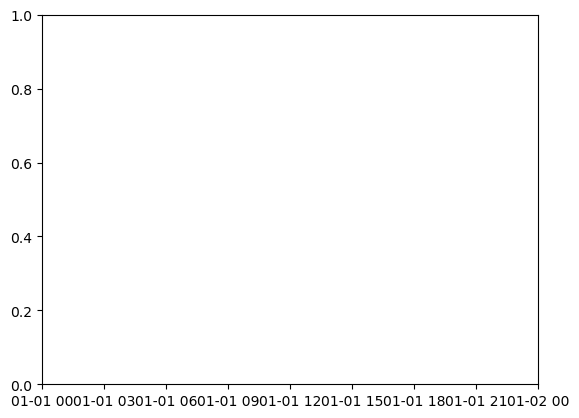

In [70]:
# time series s2
#cube_s2.ndvi.median(dim=['x', 'y']).plot.line(marker='o')
# time series ls
#cube_ls.ndvi.median(dim=['x', 'y']).plot.line(marker='o')
# time series combined
cube_ndvi.median(dim=['x', 'y']).plot.line(marker='o', vmin=0, vmax=0.8) # probably have to rechunk cube_ndvi, to mix s2 and ls time steps

# Define the computation

In [8]:
median = (cube.quantile(0.5, dim='time', skipna=True, keep_attrs=True)
          .rename({b: f'{b}_median' for b in list(cube.keys())}))
median

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830)
Coordinates:
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
    quantile     float64 0.5
Data variables:
    nir_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi_median  (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>

# Start the dask client
Here we are starting the dask client for scaling the computation to the available resources.  
Once started, a link to the dask dashboard will be shown which will display details on the dask computation status.

In [9]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status'
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
dask.config.set({'distributed.comm.timeouts.tcp': '180s',
                 'distributed.comm.timeouts.connect': '120s',
                 'distributed.dashboard.graph-max-items': 55000,
                 'distributed.deploy.lost-worker-timeout': '90s',
                 'distributed.scheduler.allowed-failures': 180,
                 })
#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,Workers: 16
Total threads: 16,Total memory: 50.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34585,Workers: 16
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,Total threads: 16
Started: Just now,Total memory: 50.00 GiB
Comm: tcp://127.0.0.1:33771,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/43495/status,Memory: 3.12 GiB
Nanny: tcp://127.0.0.1:44839,


# Start the computation
Here the actual computation is started and the result written to the output file.  
Check the dask dashboard for computation progress.

In [10]:
%%time
#ignore invalid value encountered in divide warning (ndvi divide by zero)
delayed = median.to_zarr(filename, mode='w', compute=False, consolidated=True)
dask.compute(delayed)

/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 41.1 s, sys: 3.55 s, total: 44.6 s
Wall time: 2min 35s


(None,)

In [11]:
client.cluster.close()
time.sleep(5)
client.close()

# Load and Visualize the result from File

In [12]:
result = xarray.open_zarr(filename)
result

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830)
Coordinates:
    quantile     float64 ...
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    ndvi_median  (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    nir_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>

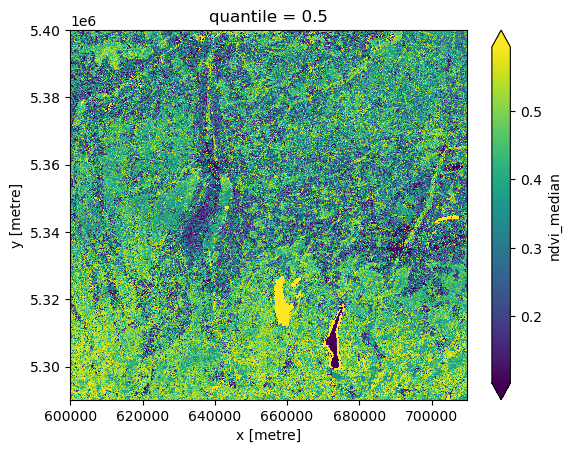

In [13]:
result.ndvi_median.plot(robust=True)

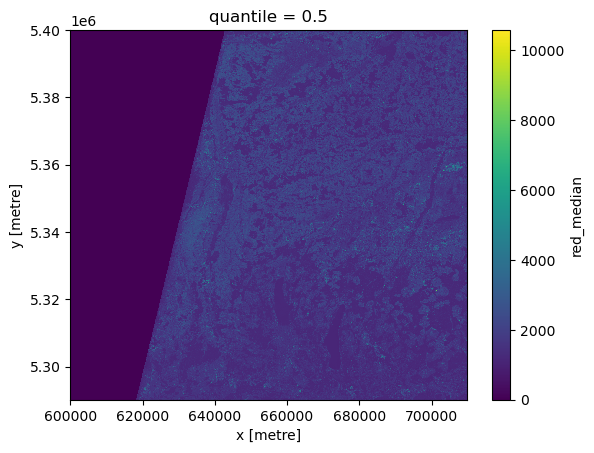

In [14]:
result['red_median'].plot()

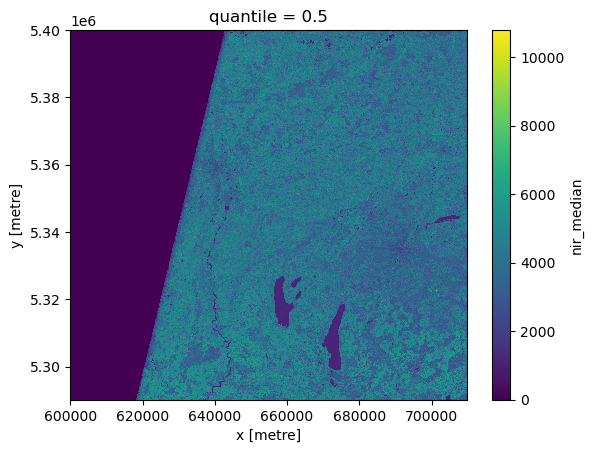

In [16]:
result['nir_median'].plot()